# Bayesian Credible Intervals

Exploring whether and how we can estimate Bayesian credible intervals for posterior probability distributions from our MCMC simulations. In particular, it is interesting to see if it will be possible to estimate credible intervals for probability distributions that are constrained by a left or right wall that is artificially imposed by our simulations (grid boundaries).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [10]:
left  = np.genfromtxt('/Users/grefe950/Software/StarBay/interbay/chains/run08/GJ896A_W0300_N0200_B0000.dat')
right = np.genfromtxt('/Users/grefe950/Software/StarBay/interbay/chains/run08/GJ15A_W0300_N0200_B0000.dat')
mid   = np.genfromtxt('/Users/grefe950/Software/StarBay/interbay/chains/run08/GJ105A_W0300_N0200_B0000.dat')

Remold the flattened MCMC chains into individual chains.

In [11]:
left_chains  = left.reshape(300, -1, 9)
right_chains = right.reshape(300, -1, 9)
mid_chains   = mid.reshape(300, -1, 9)

We can now also extract a new flattened chain using the last 50 iterations from the sample.

In [12]:
left_samp  = left_chains[:, -50:, :].reshape(-1, 9)
right_samp = right_chains[:, -50:, :].reshape(-1, 9)
mid_samp   = mid_chains[:, -50:, :].reshape(-1, 9)

It will be good to first evaluate the shape of the three posterior probability distributions for the mixing length, which poses particular problems.

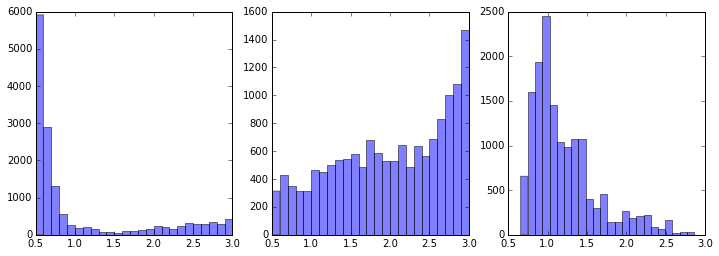

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

tmp = ax[0].hist(left_samp[:, 5], bins=25, alpha=0.5)
tmp = ax[1].hist(right_samp[:, 5], bins=25, alpha=0.5)
tmp = ax[2].hist(mid_samp[:, 5], bins=25, alpha=0.5)

As one can see, there we have adequately selected simulations whose posterior distribution functions exhibit different behaviors with respect to the simulation boundaries. Our `mid` simulation is not ideal, but does at least demonstrate a clear peak in the posterior distribution, whereas the other simulations run into a wall at either side of the artificial boundaries.

We can also compute kernel density estimates to estimate the probability density.

In [15]:
from scipy.stats import gaussian_kde

In [16]:
alphas = np.arange(0.5, 3.0, 0.005)

left_kde  = gaussian_kde(left_samp[:, 5],  bw_method='silverman')
right_kde = gaussian_kde(right_samp[:, 5], bw_method='silverman')
mid_kde   = gaussian_kde(mid_samp[:, 5],   bw_method='silverman')

Which when visualized look like

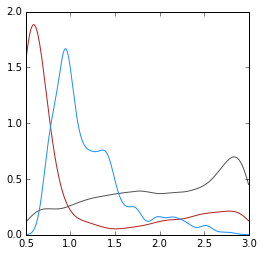

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot(alphas, left_kde(alphas),  c='#b22222')
ax.plot(alphas, right_kde(alphas), c='#555555')
ax.plot(alphas, mid_kde(alphas),   c='#1e90ff')

The kernel density estimate for our "normal" distribution (light blue) provides an adequate representation of the probability distribution that permits identification of a modal value. However, the two other kernel density estimates do not provide an adequate constraint on the probability distribution. They fail at the edges and therefore any confidence interval defined using the modal value as a "best estimate" is bound to provide a very questionable constraint on the true value. 

So, how can we estimate Bayesian credible intervals, knowing that the true values for two of the simulations show above exist outside of the simulation boundaries? 

One thought is to model the posterior probabilities as Gaussian to find a credible interval that is consistent with the observed distributions. That is, we assume the final probabilty distribution should be Gaussian such that

\begin{eqnarray}
    p(x | \theta) = \left\{
    \begin{array}{l l l}
        \left(2\pi\sigma^2\right)^{-1/2} \exp\left[ -\frac{(x - \theta)^2}{2 \sigma^2} \right] & & x > 0 \\
        0 & & x \le 0
    \end{array}
    \right.
\end{eqnarray}

We can then estimate the (log) probability for a give set of data $p({\bf X} | \theta)$ as

\begin{eqnarray}
    \log p({\bf X} | \theta) = \left\{
    \begin{array}{l l l}
        N \left(2\pi\sigma^2\right)^{-1/2} - \sum_{i = 1}^{N}\left(\frac{x_i - \theta}{2 \sigma}\right)^2 & & x > 0 \\
        0 & & x \le 0
    \end{array}
    \right.
\end{eqnarray}

To derive Bayesian credible intervals, we must integrate over the probability distribution between two values of the central value, $\theta_1$ and $\theta_2$, and set it equal to the desired credible interval, $f$. 

\begin{equation}
    N\left(2\pi\sigma^2\right)^{-1/2} \int_{\theta_1}^{\theta_2} \exp\left[ 
            - \sum_i (x_i - \theta)^2/\sigma^2 \right] d\theta = f
\end{equation}

This has a solution involving the error function.

\begin{equation}
    N\left(2\pi\right)^{-1/2} \sum_i \left[ \pi^{1/2} {\rm erf}\left( \frac{x_i - \theta_1}{2\sigma} \right) 
        - {\rm erf}\left( \frac{x_i - \theta_2}{2\sigma} \right)\right] = f
\end{equation}

We can attempt to derive a credible interval under the assumption that the Gaussian probability is symmetric about the most likely value.

In [87]:
from scipy.special import erf

N = left_samp.shape[0]
sigma = 0.1

values = 0.
for theta in np.arange(0.01, 1.0, 0.01):
    for theta_2 in (theta + np.arange(sigma, 5.*sigma, 0.05)):
        f = np.sum(np.pi**0.5*erf((left_samp[:, 5] - theta)/(2.*sigma)) - erf((left_samp[:, 5] - theta_2)/(2.*sigma)))
        #f = f*(2.*np.pi)**(-N/2)
        try:
            values = np.vstack((values, np.array([theta, theta_2, f])))
        except:
            values = np.array([theta, theta_2, f])
np.savetxt('data/credible_intervals.txt', values, fmt='%12.6e')

Explore how values of $f$ look as a funciton of $\theta$ and $\theta_2$.

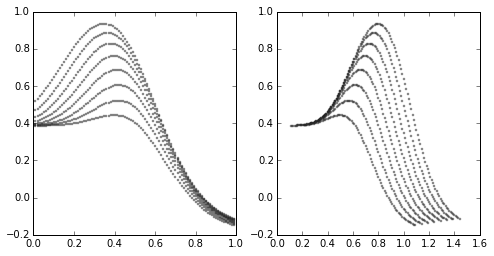

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(8., 4.))

ax[0].plot(values[:, 0], values[:, 2]/30000., 'o', markersize=2.0, c='#555555', alpha=0.5)
ax[1].plot(values[:, 1], values[:, 2]/30000., 'o', markersize=2.0, c='#555555', alpha=0.5)

Let's instead aim for a 3D visualization.

In [30]:
from mpl_toolkits.mplot3d import Axes3D

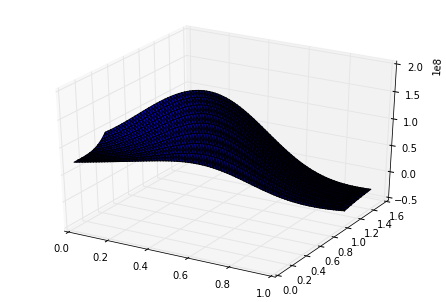

In [47]:
fig = plt.figure()
ax = Axes3D(fig)

ax.plot_trisurf(values[:, 0], values[:, 1], values[:, 2])